# Introduction

This notebook will present a couple of solutions for the issue of classifying a name as belonging to an individual or a company. This type of problem is known as NER (named entity recognition) and there are a considerable number of solutions and datasets that one can find for it online.

The document starts with an exploratory analysis, which aims to find issues in the dataset, gather insights on how to solve the problem, and give a general understanding of the data.

Following that, we will create a baseline model. This model will give us a benchmark for this problem and dataset. We will then try to beat this benchmark with two other models.

## Initial EDA

In [5]:
import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from tensorflow.keras.optimizers import Adam
from keras.models import Model

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from datasets import Dataset

import matplotlib.pyplot as plt

from scipy.sparse import hstack

from tensorflow.keras import mixed_precision
# NVIDIA GPUs can run operations in float16 faster than in float32
# we might want to comment the following line for production
mixed_precision.set_global_policy('mixed_float16') 

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2023-02-22 22:43:47.806912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


2023-02-22 22:43:49.907378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 22:43:49.910272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 22:43:49.910600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-22 22:43:49.911022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
def open_file(file_name):
    with open(file_name, "r") as file:
        dataset = pd.DataFrame(file.read().split("\n"), columns=["text"])
        dataset = dataset[dataset.text!=""] # removing a empty line in the last line 
    return dataset

df_companies = open_file("companies.txt").assign(label=1) # we label the data here
df_individuals = open_file("individuals.txt").assign(label=0)

### Eyeballing the data

Below, we take a look at the data, and with some common sense, some patterns are seen, like:
1. Words like Club or Auto probably indicate a business
2. Places are probably more common in businesses' names as well (e.g. Hawaii, Albuquerque)
3. Many times, you can find the meaning of the words that compose a company name in a dictionary (e.g. Electrolysis, Primos)
4. First names are normally familiar (David, Angel, Erika, etc)

We will later deep-diving into point 1 by checking the common words in the dataset

Also important, the dataset is relatively well balanced with ~63% being companies, and classifying companies or individuals correctly seems equaly important, so we can use metrics like accuracy to measure the quality of our models. If the dataset was unbalanced, we would favor metrics that consider the trade-off between precision and recall, like the area under the curve in a precision-recall curve. I will also be checking the area under the curve for ROC curves, simply because I am used to ranking problems where this is a common metric and thus it will help me to get a "feeling" of the problem here.

In [7]:
print(df_companies.shape)
df_companies.head()

(161055, 2)


,text,label
0,Albuquerque Dsm Club,1
1,Teriyaki Hawaii,1
2,Allure Electrolysis Waxing,1
3,Los Primos Auto Sales,1
4,John Wesselius,1


In [8]:
print(df_individuals.shape)
df_individuals.head()

(94246, 2)


,text,label
0,David Kagan,0
1,Angel Donchev,0
2,Erika Parisi,0
3,Rebecca Healey,0
4,Clifford Irwin,0


In [9]:
df_companies.isnull().sum(), df_individuals.isnull().sum()

(text     0
 label    0
 dtype: int64,
 text     0
 label    0
 dtype: int64)

## EDA Deep-dive: Checking frequencies

### Frequency of words

From the individuals, we can see that this dataset probably comes from English-speaking contries. Common first names again seem to be a great predictor (as we have seen when eveyballing the data). So a word by word enconding seems promissing for our models.

From the companies, we can see abbreviations stand out. The '&' is also interesting, let's see next what are the most common symbols in the datasets.

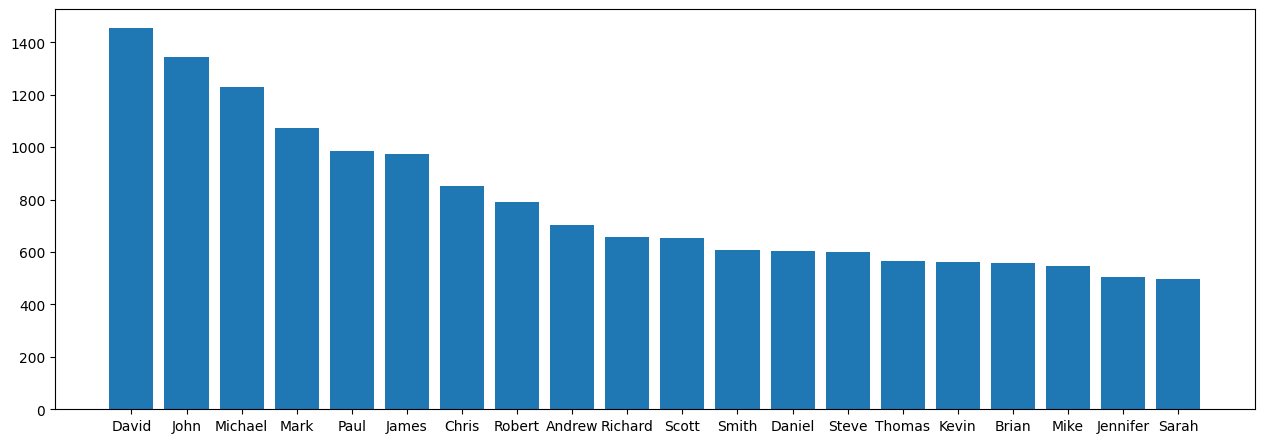

In [10]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
name_freq = df_individuals.text.str.split(" ").explode().value_counts()
ax.bar(name_freq[:20].index, name_freq[:20])
plt.show()

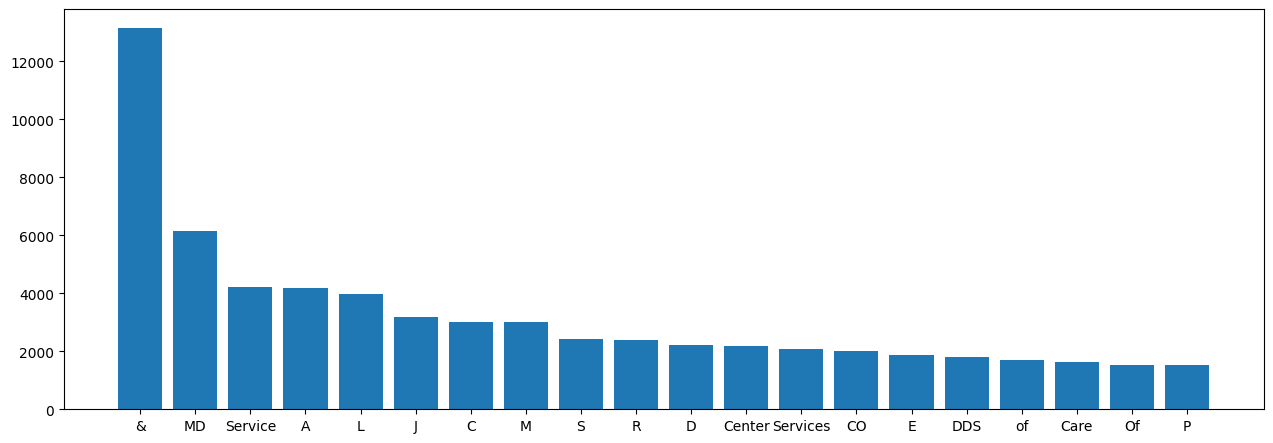

In [11]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
name_freq = df_companies.text.str.split(" ").explode().value_counts()
ax.bar(name_freq[:20].index, name_freq[:20])
plt.show()

### Frequency of caracters

Symbols are more common and more diverse in companies' names (even considering we have a bigger dataset on companies). Numerals only exist in companies' names. So a character enconding also seems like a must-have.

Checking symbols was also a good check on whether we have invalid characters

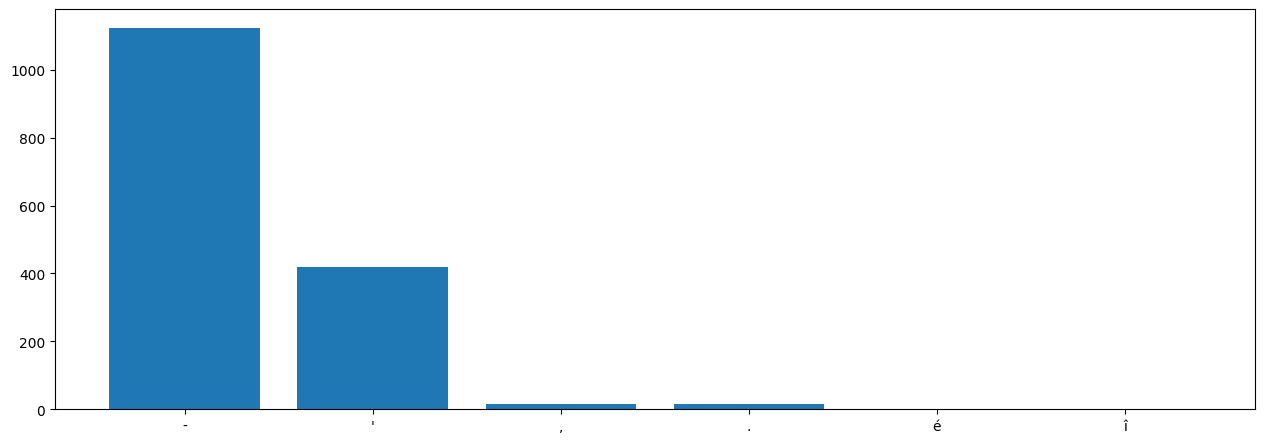

In [12]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
caracters = df_individuals.text.apply(lambda x: list(x)).explode()
caracters = caracters[~caracters.str.contains(r'[a-z ]+', flags=re.IGNORECASE, regex=True)].value_counts()
ax.bar(caracters.index, caracters)
plt.show()

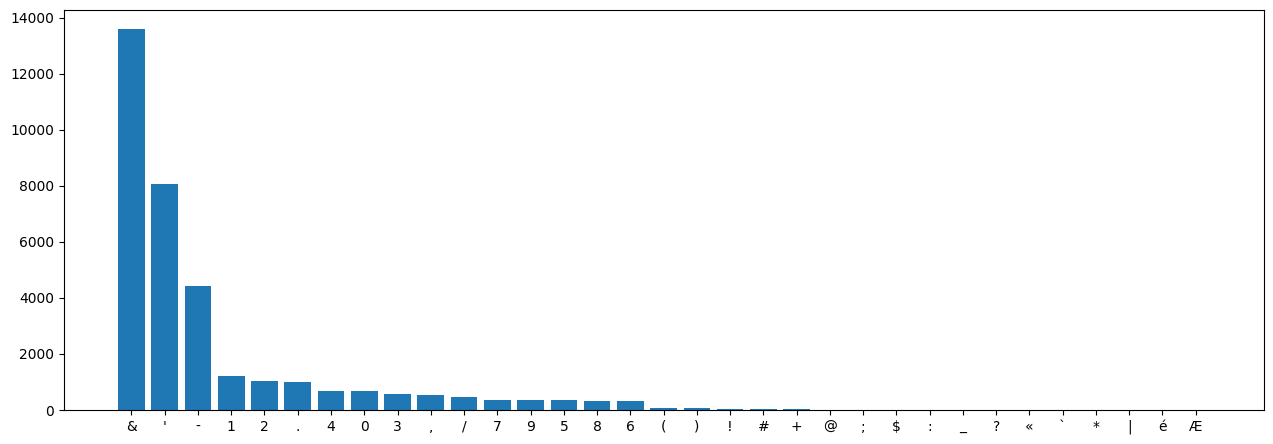

In [13]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
caracters = df_companies.text.apply(lambda x: list(x)).explode()
caracters = caracters[~caracters.str.contains(r'[a-z ]+', flags=re.IGNORECASE, regex=True)].value_counts()
ax.bar(caracters.index, caracters)
plt.show()

### Number of words

Unless you're the Pope, the Queen, or Pelé, you probably have at least two names. So the number of words itself can be a predictor.

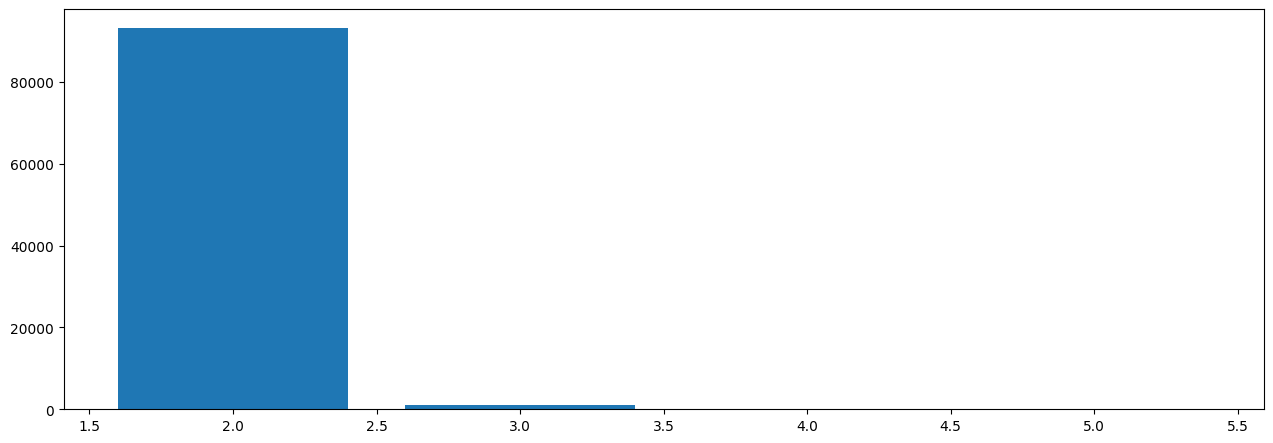

In [14]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
size_freq = df_individuals.text.str.split(" ").apply(lambda x: len(x)).value_counts()
ax.bar(size_freq[:20].index, size_freq[:20])
plt.show()

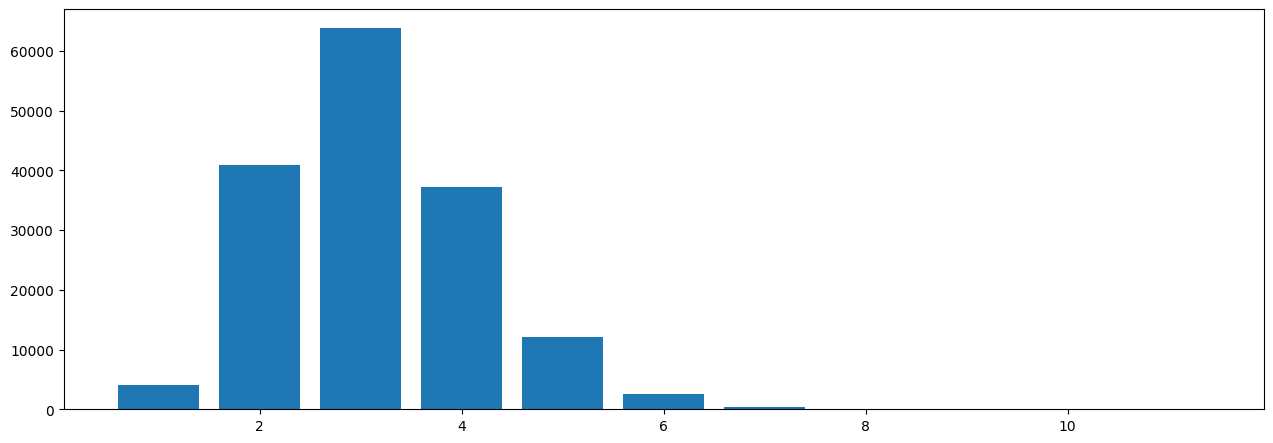

In [15]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
size_freq = df_companies.text.str.split(" ").apply(lambda x: len(x)).value_counts()
ax.bar(size_freq[:20].index, size_freq[:20])
plt.show()

In [16]:
# check if there are double spaces as it could indicate an issue with the dataset
df_individuals[df_individuals.text.str.contains(r'  ', flags=re.IGNORECASE, regex=True)]

,text,label


## Baseline Model

Our baseline model will be the simplest binary classifier I know of, the Logistic Regression, basically a linear model with the logistic function at the end of it to convert the output to something between 0 and 1, so we use as a probability. When the probability is bigger than 0.5, we classify the sample as being a company (since we labeled companies as 1s).

Scikit-learn implementation also has by default a l2 (or Ridge) regularization, which can help it to generalize better the results in the train dataset (although overfitting wouldn't be huge concern of mine at this moment).

In [17]:
# we split the dataset into 3 parts.
# One for train, with 64% of the data
# Another for validation with 16% of the data
#   which(can be used to choose the best model and for hyperparameter optimization)
# And another 20% for a final test, done only with the best model
#  the result with the test dataset will give us the expected performance on production

# also important, we do the split separately in the companies and the individuals datasets,
# as I want to keep the proportion of each category the same everywhere
# I checked sklearn split methods and didn't find a way to it in one go

df_companies_train, df_companies_test = train_test_split(df_companies, test_size=0.2, random_state=42)
df_companies_train, df_companies_eval = train_test_split(df_companies_train, test_size=0.2, random_state=42)

df_individuals_train, df_individuals_test = train_test_split(df_individuals, test_size=0.2, random_state=42)
df_individuals_train, df_individuals_eval = train_test_split(df_individuals_train, test_size=0.2, random_state=42)

In [18]:
df_train = pd.concat([df_companies_train, df_individuals_train])
df_eval = pd.concat([df_companies_eval, df_individuals_eval])
df_test = pd.concat([df_companies_test, df_individuals_test])

In [43]:
# we will have char and word counts as features, as we have seen in the EDA that both seem relevant
# limiting the vocab size -- about 5k words appear at least 10 times in this dataset
word_vectorizer = CountVectorizer(min_df=10)
char_vectorizer = CountVectorizer(analyzer="char", ngram_range=(1, 2))

# concatenating features
vectorized_train_data = hstack(
    (word_vectorizer.fit_transform(df_train.text.tolist()), char_vectorizer.fit_transform(df_train.text.tolist()))
)

In [20]:
# declarind and fitting the model
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(vectorized_train_data, df_train.label.tolist())

LogisticRegression(max_iter=1000, random_state=42)

In [64]:
coeficients = pd.DataFrame({
    "word": np.concatenate([word_vectorizer.get_feature_names_out(), char_vectorizer.get_feature_names_out()]),
    "coef": clf.coef_[0]
})
coeficients["abs_coef"] = np.abs(coeficients["coef"])
coeficients.sort_values(by=["abs_coef"], ascending=False).head(10)

,word,coef,abs_coef
4168,salon,4.262897,4.262897
5424,/,3.958860,3.958860
956,co,3.898370,3.898370
1241,dds,3.570295,3.570295
2148,hector,-3.551720,3.551720
5507,2,3.547996,3.547996
4948,victoria,-3.362653,3.362653
4947,victor,-3.333975,3.333975
4712,the,3.313548,3.313548
2306,ian,-3.281419,3.281419


In [65]:
coeficients.sort_values(by=["abs_coef"], ascending=True).head(10)

,word,coef,abs_coef
5539,2t,0.000002,0.000002
6285,n8,0.000002,0.000002
5392,.-,0.000002,0.000002
5283,&z,0.000002,0.000002
5627,5i,0.000002,0.000002
6480,s0,0.000002,0.000002
5480,1),0.000002,0.000002
5319,(5,0.000002,0.000002
6329,o:,0.000002,0.000002
5734,@,0.000002,0.000002


In [15]:
# applying the same transformation to the validation dataset and predicting
vectorized_val_data = hstack(
    (word_vectorizer.transform(df_eval.text.tolist()), char_vectorizer.transform(df_eval.text.tolist()))
)
val_pred = clf.predict(vectorized_val_data)
val_pred_proba = clf.predict_proba(vectorized_val_data)[:,1]

In [16]:
# getting metrics
accuracy_score(df_eval.label.tolist(), val_pred), roc_auc_score(df_eval.label.tolist(), val_pred_proba)

(0.9127028813434845, 0.9591124786706788)

In [34]:
confusion_matrix(df_eval.label.tolist(), val_pred) / df_eval.shape[0]

array([[0.34536953, 0.02379495],
       [0.06350217, 0.56733335]])

## Comments on the quality of the baseline model

In my experience with ranking problems, AUC ROC > 80% are great already, when we got to this level, the business benefit of further improvements were marginal and the team would move to other priorities.

But thinking on the cases this model might be applied, 91% accuracy might still not be great. If, for instance, having an company name in a field for individuals is a fraud, firing an alarm for a human to review once every 10 fields seems problematic. So it seems worth to pursue improvements here.

Also, it seems it's harder to classify company names, as our model was better with individuals even thought we had more samples in the company category.

Let's check the biggest mistakes and see if we can get some extra insight.

In [33]:
df_eval["pred_baseline"] = clf.predict_proba(vectorized_val_data)[:,1]
df_eval["abs_error"] = df_eval.apply(lambda x: abs(int(x["label"]) - x["pred_baseline"]), axis=1)

In [34]:
df_eval[df_eval.label!=(df_eval.pred_baseline>0.5)].sort_values(by=["pred_baseline"]).head(10)

,text,label,pred_baseline,abs_error
3683,jhijhkjhijhijh,1,0.000346,0.999654
58318,Egri Zsuzsi,1,0.006193,0.993807
118386,kevikevdottcom,1,0.007060,0.992940
144725,Ziji,1,0.007665,0.992335
134789,Anjali,1,0.009885,0.990115
39036,Alison Copeland,1,0.011028,0.988972
97641,Jianguo Li,1,0.012595,0.987405
120212,Scott Gavin,1,0.012595,0.987405
37273,jobhotwire,1,0.012662,0.987338
58358,Rick Oliver,1,0.012738,0.987262


Looking at the top companies misclassified, I had some insights:
1. the most obvious and expected one: many companies' names are named after persons without any addition like Inc or LLC, so not much that a model or a human can do here
2. we possibly have issues of mispelling in our dataset, perhaps this is a predictor by itself, moreover, more powerful models like pre-trained Transformers could handle mispelling
3. one positive thing: the baseline model seems to not have an issue with non-occidental names, it thought that Jianguo Li (likely Chinese) was a person name
4. The model didn't learn that one word = likely a company
5. The lack of spaces separating words might be hindering the model performance, like if kevikevdottcom was "kevikev dott com", the "com" word could have been key for a correct prediction 

If the model will be deployed outside North America and Europe, point 3 might be particurlarly important and worth exploring more.

In [35]:
df_eval[df_eval.label!=(df_eval.pred_baseline>0.5)].sort_values(by=["pred_baseline"], ascending=False).head(10)

,text,label,pred_baseline,abs_error
37750,Barum Jeffries Acc,0,0.994885,0.994885
24285,William Maiorino Jr,0,0.990820,0.990820
85522,Wilt Dirk Vande,0,0.989732,0.989732
57333,Roger J Cline,0,0.987866,0.987866
3478,Md Rabbi,0,0.986164,0.986164
55362,Linda Just Blackman,0,0.983481,0.983481
70739,Richard Gow Policy Analyst,0,0.981449,0.981449
84704,Marks Michelle Do,0,0.980394,0.980394
3624,Friedman Rolf Doki,0,0.978722,0.978722
92472,Sixto R Caro,0,0.974939,0.974939


Looking at the mistakes on individuals' names makes me think that:
1. Our dataset contains extra information for the people, like their position at the company, e.g. "Richard Gow Policy Analyst"
2. Abbreviations seem to mislead the model here

## Model number 2: a custom NN

Looking at the failures of our baseline model, it seems a pre-trained transformer would be ideal to our case. Moreover, with less than 1MM samples and no further contextual features, it seems unlikely that a custom model will beat a pre-trained model.

Nevertheless, a custom NN can have its advantage, you have more freedom with it and it can be much faster to train. Besides, we could obtain more data in the future. So I wanted to try out something quick here.

In [139]:
# Again, we need to vectorize our text
vectorize_layer_words = tf.keras.layers.TextVectorization(
    max_tokens=5000, 
    output_mode='int', # Outputs integer indices, one integer index per split string token
    output_sequence_length=10
)

vectorize_layer_ngrams = tf.keras.layers.TextVectorization(
    max_tokens=1000,
    output_mode='int',
    output_sequence_length=42,
    ngrams=(1, 2), # create char n-grams of 1 and 2
    split="character"
)

# learning the vocab
text_dataset = tf.data.Dataset.from_tensor_slices(df_train.text.tolist())
vectorize_layer_words.adapt(text_dataset.batch(64))
vectorize_layer_ngrams.adapt(text_dataset.batch(64))

In [140]:
# defining string input and adding vectorize layers
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)

In [141]:
outputs = tf.keras.layers.Concatenate()(
    [
        tf.keras.layers.GlobalAveragePooling1D()(
            tf.keras.layers.Embedding(5000, 32)(vectorize_layer_words(inputs))
        ),
        tf.keras.layers.GlobalAveragePooling1D()(
            tf.keras.layers.Embedding(1000, 32)(vectorize_layer_ngrams(inputs))
        ),
    ]
)

In [142]:
# An extra hidden layer
outputs = tf.keras.layers.Dense(32, activation="relu")(outputs)

In [143]:
# Finally our output layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(outputs)

In [144]:
model = Model(inputs=inputs, outputs=outputs)

In [145]:
model.compile(
    optimizer=Adam(3e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [146]:
hist = model.fit(
    np.array(df_train["text"]), np.array(df_train["label"]),
    validation_data=(np.array(df_eval["text"]), np.array(df_eval["label"])),
    epochs=15,
)

Epoch 1/15
5106/5106 [==============================] - 47s 9ms/step - loss: 0.5589 - accuracy: 0.7050 - val_loss: 0.4428 - val_accuracy: 0.7928
Epoch 2/15
5106/5106 [==============================] - 31s 6ms/step - loss: 0.4005 - accuracy: 0.8132 - val_loss: 0.3715 - val_accuracy: 0.8289
Epoch 3/15
5106/5106 [==============================] - 31s 6ms/step - loss: 0.3415 - accuracy: 0.8504 - val_loss: 0.3190 - val_accuracy: 0.8641
Epoch 4/15
5106/5106 [==============================] - 31s 6ms/step - loss: 0.2957 - accuracy: 0.8786 - val_loss: 0.2817 - val_accuracy: 0.8855
Epoch 5/15
5106/5106 [==============================] - 32s 6ms/step - loss: 0.2648 - accuracy: 0.8954 - val_loss: 0.2578 - val_accuracy: 0.8983
Epoch 6/15
5106/5106 [==============================] - 31s 6ms/step - loss: 0.2449 - accuracy: 0.9050 - val_loss: 0.2426 - val_accuracy: 0.9050
Epoch 7/15
5106/5106 [==============================] - 31s 6ms/step - loss: 0.2314 - accuracy: 0.9107 - val_loss: 0.2323 - val_ac

In [153]:
# getting metrics
accuracy_score(df_eval.label.tolist(), predict>0.5), roc_auc_score(df_eval.label.tolist(), predict)

(0.9224460819114298, 0.9664455062541475)

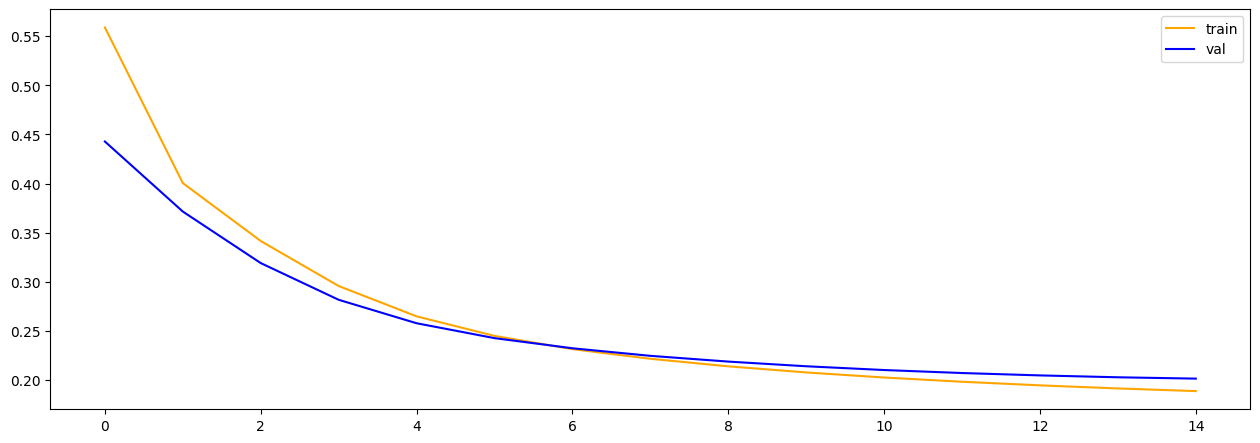

In [154]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
ax.plot(list(range(len(hist.history["loss"]))), hist.history["loss"], color="orange", label='train')
ax.plot(list(range(len(hist.history["val_loss"]))), hist.history["val_loss"], color="blue", label='val')
ax.legend()
plt.show()

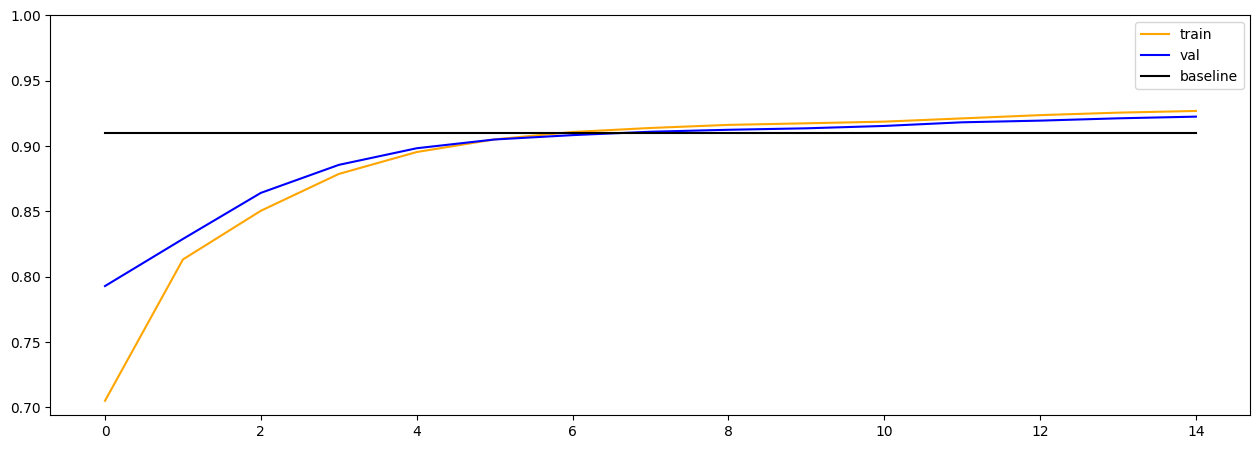

In [155]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
x_axis = list(range(len(hist.history["accuracy"])))
ax.plot(x_axis, hist.history["accuracy"], color="orange", label='train')
ax.plot(x_axis, hist.history["val_accuracy"], color="blue", label='val')
ax.plot(x_axis, [0.91] * len(x_axis), color="black", label='baseline')
ax.set_ylim([None, 1])
ax.legend()
plt.show()

### Some thoughts on the custom NN

The general process I follow when training neural networks:
1. add more and more power (more layers, more neurons, LSTM, attention, etc) until I start to overfit;
1. then I start to add regularization to the network (L1/L2 weights, dropout, batch normalization, etc).

By the plots above, we cleared didn't start to overfit, so we are probably still underfitting and there is learning to be extract from the data, so I won't add regularization here. The fact that we didn't even reach the baseline is further evidence for undefitting.

We can also see that adding more epochs alone probably won't solve the problem.

# Final model: Transformer

We will use a pre-trained transformer called BERT by Google. We have already pointed out some reasons to believe that a transformer is a good idea, so here I would like to justify why BERT specifically: it can understand the position of the words in a sentence. We haven't explored it in the EDA or in the other models, but this might be important, like, John is a common first name but not last name, or LLC or Inc. will be added to the end of the company's name but not at beginning.

With more time, we could explore combining different transformers, one that process characters + BERT and tying them together by concatenating and plugging their last hidden layer to another NN.

In [17]:
# we start in the same way, converting words to something that the model understands

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_tokens = dict(tokenizer(df_train["text"].tolist(), return_tensors="np", padding=True))
eval_tokens = dict(tokenizer(df_eval["text"].tolist(), return_tensors="np", padding=True))
test_tokens = dict(tokenizer(df_test["text"].tolist(), return_tensors="np", padding=True))

In [18]:
# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")

# Lower learning rates are often better for fine-tuning transformers
# No need to provide a loss function as the transformer already has a bespoken internal loss function
model.compile(
    optimizer=Adam(3e-5),
    metrics=['accuracy']
)

hist = model.fit(
    train_tokens, np.array(df_train["label"]),
    validation_data=(eval_tokens, np.array(df_eval["label"])),
    epochs=3
)

2023-02-16 16:42:40.042009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 16:42:40.472862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22284 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c7:00.0, compute capability: 8.6
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified i

Epoch 1/3


2023-02-16 16:43:07.233738: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2240009d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-16 16:43:07.233776: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-02-16 16:43:07.270195: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-16 16:43:08.285399: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5106/5106 [==============================] - 534s 97ms/step - loss: 0.1536 - accuracy: 0.9488 - val_loss: 0.1440 - val_accuracy: 0.9507
Epoch 2/3
5106/5106 [==============================] - 486s 95ms/step - loss: 0.1305 - accuracy: 0.9564 - val_loss: 0.1422 - val_accuracy: 0.9518
Epoch 3/3
5106/5106 [==============================] - 487s 95ms/step - loss: 0.1133 - accuracy: 0.9616 - val_loss: 0.1464 - val_accuracy: 0.9515


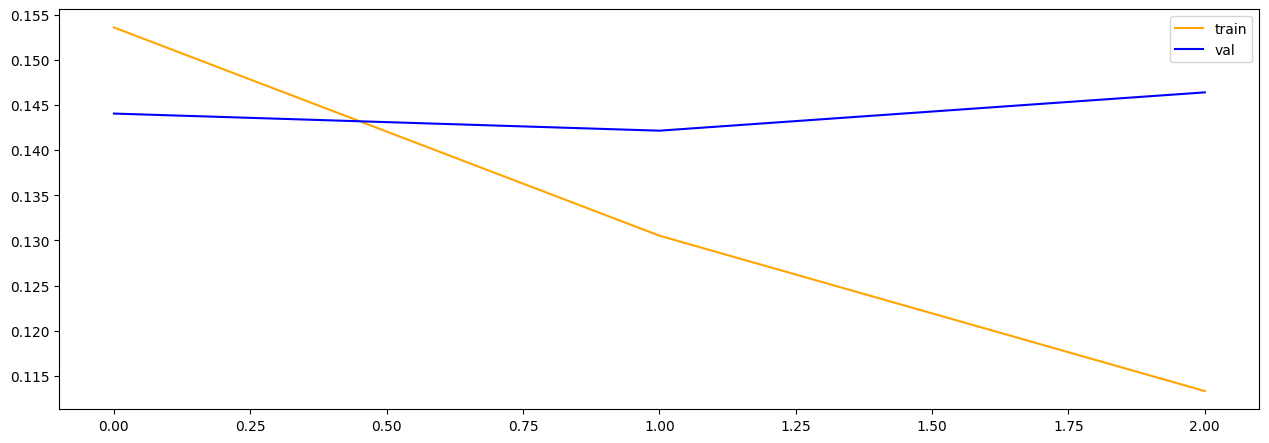

In [19]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
ax.plot(list(range(len(hist.history["loss"]))), hist.history["loss"], color="orange", label='train')
ax.plot(list(range(len(hist.history["val_loss"]))), hist.history["val_loss"], color="blue", label='val')
ax.legend()
plt.show()

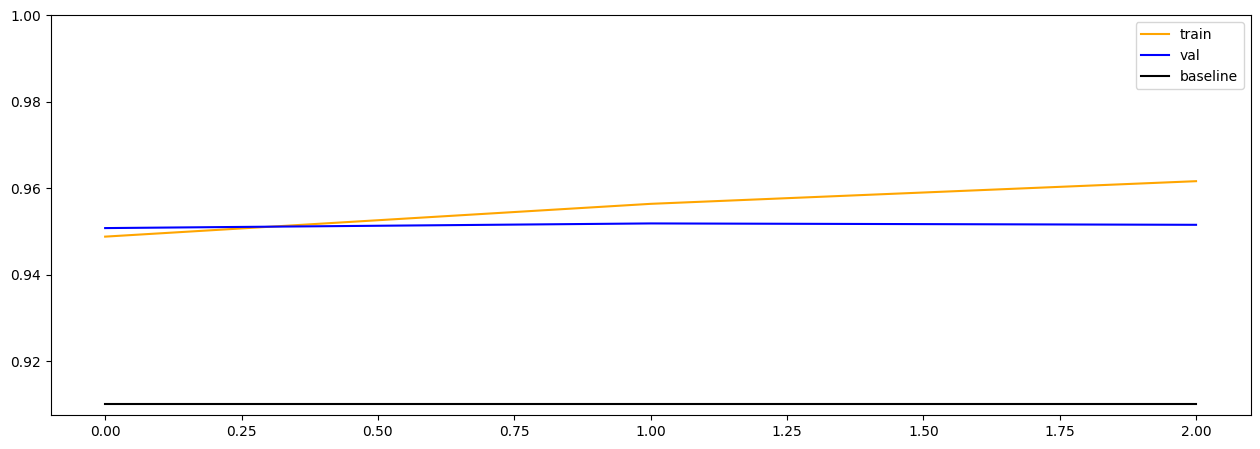

In [20]:
fig = plt.figure(figsize=(12, 4), dpi=100)
ax = fig.add_axes([0,0,1,1])
x_axis = list(range(len(hist.history["accuracy"])))
ax.plot(x_axis, hist.history["accuracy"], color="orange", label='train')
ax.plot(x_axis, hist.history["val_accuracy"], color="blue", label='val')
ax.plot(x_axis, [0.91] * len(x_axis), color="black", label='baseline')
ax.set_ylim([None, 1])
ax.legend()
plt.show()

### Some comments on the new model

With a more powerful model, we seem to finaly see some overfitting, as the validation loss increases in the third epoch, and accuracy is improving slower in the validation than in the train set.

It's important to note that the loss function for the custom NN is not the same as the one used in BERT, so the loss plots are not comparable.

In [22]:
val_logits = model.predict(eval_tokens).logits

1277/1277 [==============================] - 39s 29ms/step


In [26]:
def logits_to_prob(logits):
    return 1 / (1 + np.exp(-logits))

df_eval["pred_transformer"] = logits_to_prob(val_logits[:,1])
df_eval["abs_error_transf"] = df_eval.apply(lambda x: abs(int(x["label"]) - x["pred_transformer"]), axis=1)

In [31]:
(
    accuracy_score(df_eval["label"], df_eval["pred_transformer"]>0.5),
    roc_auc_score(df_eval["label"], df_eval["pred_transformer"])
)

(0.9508923107052805, 0.9804253856931091)

In [35]:
# The new model performs better than the baseline on classifying both companies and individuals
confusion_matrix(df_eval.label.tolist(), df_eval["pred_transformer"]>0.5) / df_eval.shape[0]

array([[0.35636123, 0.01280325],
       [0.03630444, 0.59453108]])

In [32]:
df_eval[df_eval.label!=(df_eval.pred_transformer>0.5)].sort_values(by=["pred_transformer"]).head(10)

,text,label,pred_transformer,abs_error_transf
39036,Alison Copeland,1,0.096191,0.903809
96109,Tracey Whaley,1,0.098206,0.901794
127968,Tonya Kidd,1,0.099976,0.900024
68316,Tony Ross,1,0.100525,0.899475
33531,Amina Munshi,1,0.100708,0.899292
120212,Scott Gavin,1,0.103210,0.896790
54043,Sarah Atherton,1,0.103699,0.896301
33813,Adam Gillund,1,0.105591,0.894409
71156,Christie Kerr,1,0.107666,0.892334
34743,Amzad Khan,1,0.107849,0.892151


In [33]:
(
    df_eval[df_eval.label!=(df_eval.pred_transformer>0.5)]
    .sort_values(by=["pred_transformer"], ascending=False).head(10)
)

,text,label,pred_transformer,abs_error_transf
19591,Drifa Landmark,0,0.985352,0.985352
61519,Bhatia Bikramjit S,0,0.985352,0.985352
61836,Hershey Trade,0,0.985352,0.985352
53376,Fulton Brad R,0,0.985352,0.985352
24285,William Maiorino Jr,0,0.985352,0.985352
16505,Mansion House,0,0.985352,0.985352
61429,Yan-Jiang Lv,0,0.985352,0.985352
70739,Richard Gow Policy Analyst,0,0.985352,0.985352
66473,Asterious Toutios,0,0.985352,0.985352
28870,Ramsgateseafront Mgr,0,0.984375,0.984375


### Some comments on the worse mistakes

The top 10 of companies misclassified looks incredible, I wouldn't have guessed these correctly as well. And it seems it solved all the problems we noticed with the baseline model.

But looking at individuals misclassified, it seems that the same problems misled the model (namely, abbreviations and extra information like job position). It is also important to investigae if there is a tendency of failing with non-English names like "Bhatia Bikramjit S" or "Yan-Jiang Lv" as these types of biases can be damaging when entering new markets.

# Final Test

Here, I present our final accuracy and ROC AUC numbers. As mentioned before, the test dataset can give us the expected performance on production, since it is unseen data for the model, not have been used for model selection or training.

If we start to observe a worse performance on production (with the deployed model), it might be that we have a sampling bias when collecting the dataset provided, or that there is a feature shift.

In [36]:
logits = model.predict(test_tokens).logits
probabilities = logits_to_prob(logits[:,1])
accuracy_score(df_test["label"], probabilities>0.5), roc_auc_score(df_test["label"], probabilities)

1596/1596 [==============================] - 50s 30ms/step


(0.9490413427077418, 0.980294734314447)

# Final Words

We were able to deliver a model to classify whether names are from individuals or companies with an accuracy of 95% using an implementation of the BERT transformer. This model easily beats our baseline of 91% obtained with Logistic Regression.

A ~4 p.p. improvement over the baseline is big if this model is used to flag possible tampered information in a doc, this means that a human reviewer would deal with 1 in 20 false alarms instead of 1 in 11 from the baseline model, almost twice as good.